In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [2]:
rs=121
stocks=['aapl','googl','nvda','dal','xom','cvx','vz']

In [8]:
init_dir_path = str(os.getcwd())
data=pd.read_csv(init_dir_path+'/stock_hmm_output_kalman.csv',engine='python').drop(['Unnamed: 0'],axis=1)
features=['Smooth_Return','Volatility','Smooth_HighR','Smooth_LowR']
target='State'

In [10]:
final_test=[]
stocks_data=[]
ft_size=400
for x in data.groupby(['Ticker']):
    final_test.append(x[1][-ft_size:])
    stocks_data.append(x[1][:-ft_size])

In [11]:
def create_sliding_window(train_df, test_df, features, target, window=7):
    splitter = SlidingWindowSplitter(window_length=window, step_length=1, fh=[1])
    train_x, train_y, test_x, test_y = [], [], [], []

    for idx in splitter.split(train_df):
        X = train_df.iloc[idx[0]][features].values.flatten()
        y = train_df.iloc[idx[1]][target].values.flatten()[0]
        train_x.append(X)
        train_y.append(y)

    for idx in splitter.split(test_df):
        X = test_df.iloc[idx[0]][features].values.flatten()
        y = test_df.iloc[idx[1]][target].values.flatten()[0]
        test_x.append(X)
        test_y.append(y)

    return (train_x, train_y), (test_x, test_y)

In [12]:
testing_size=500
ns=5
tss=TimeSeriesSplit(n_splits=ns,test_size=testing_size)
spread_range = range(2, 25)

Skip the two cells below if you have access to the saved training windows

In [13]:
training_lists = {}
testing_lists = {}
for spread in spread_range:
    training_lists[spread] = {}
    testing_lists[spread] = {}
    for ticker_idx, ticker_df in enumerate(stocks_data):
        ticker = list(ticker_df["Ticker"])[0]
        training_list = [[[], []] for _ in range(ns)]
        testing_list = [[[], []] for _ in range(ns)]
        for fold_idx, (train_idx, test_idx) in enumerate(tss.split(ticker_df)):
            train_df = ticker_df.iloc[train_idx]
            test_df = ticker_df.iloc[test_idx]           
            (train_x, train_y), (test_x, test_y) = create_sliding_window(train_df, test_df, features, target, window=spread)
            training_list[fold_idx][0] += train_x
            training_list[fold_idx][1] += train_y
            testing_list[fold_idx][0] += test_x
            testing_list[fold_idx][1] += test_y
        training_lists[spread][stocks.index(ticker)] = training_list
        testing_lists[spread][stocks.index(ticker)] = testing_list #spread->stock index->time series split->data/label

In [14]:
with open('saved_training_kalman.pkl', 'wb') as f:
    pickle.dump(training_lists, f)

with open('saved_testing_kalman.pkl', 'wb') as f:
    pickle.dump(testing_lists, f)

Load training, test windows here. 
They're saved for complexity reasons, RUN CODE from here

In [15]:
with open('saved_training_lists.pkl', 'rb') as f:
    training_lists = pickle.load(f)

with open('saved_testing_lists.pkl', 'rb') as f:
    testing_lists = pickle.load(f)

In [16]:
def accuracies_model(model_dict, window, stock_ind, map=True):
    a=0 
    if map:
        model = model_dict[window][stock_ind]
    else:
        model = model_dict
    for i in range(ns):
        model.fit(X=training_lists[window][stock_ind][i][0],y=training_lists[window][stock_ind][i][1])
        a+= accuracy_score(model.predict(testing_lists[window][stock_ind][i][0]),testing_lists[window][stock_ind][i][1])
    a=a/ns
    return a

In [17]:
def plot_accuracies(accuracies, model_type): #accuracies needs to be a nested dictionary window->stock index
    for stock_ind in range(len(stocks)):
        vals = []
        for window in accuracies.keys():
            vals.append(accuracies[window][stock_ind])
        plt.figure(figsize=(6, 4))
        plt.plot(list(accuracies.keys()), vals, marker='o')
        plt.title(f"{model_type} accuracy scores for {stocks[stock_ind]}")
        plt.xlabel("Window size")
        plt.ylabel("accuracy")
        plt.tight_layout()
        plt.show()

c:\Users\18585\anaconda3\envs\erdos_spring_2025\Lib\site-packages\xgboost\core.py:729: UserWarning: [02:37:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


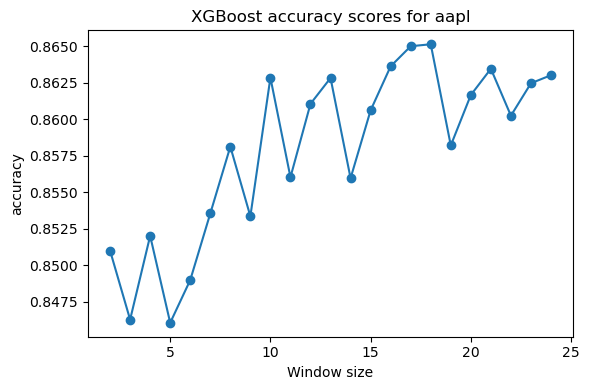

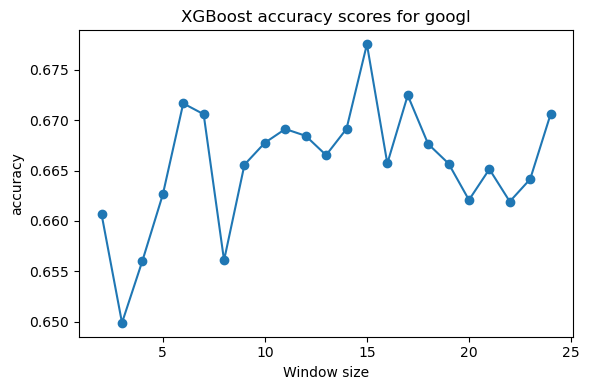

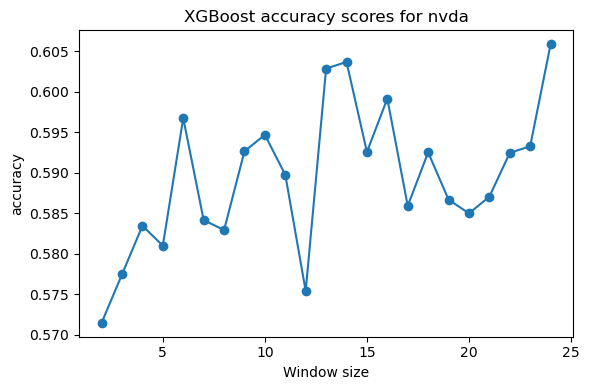

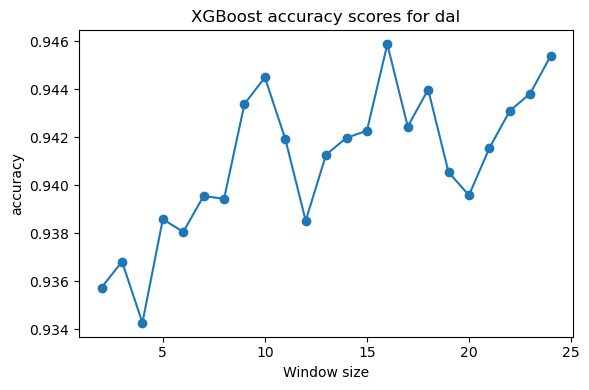

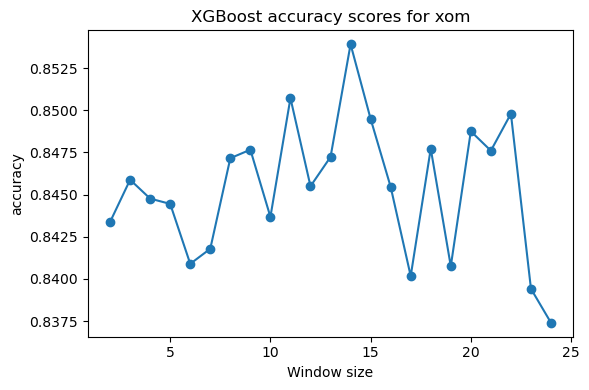

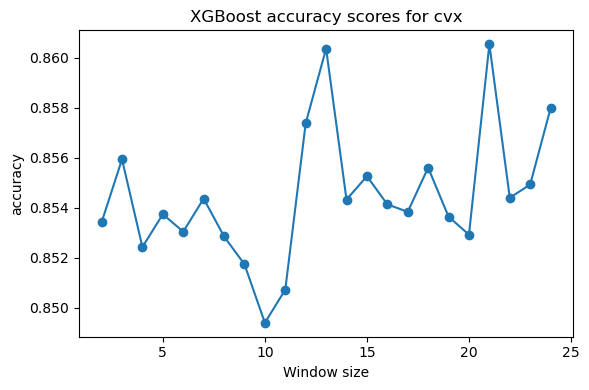

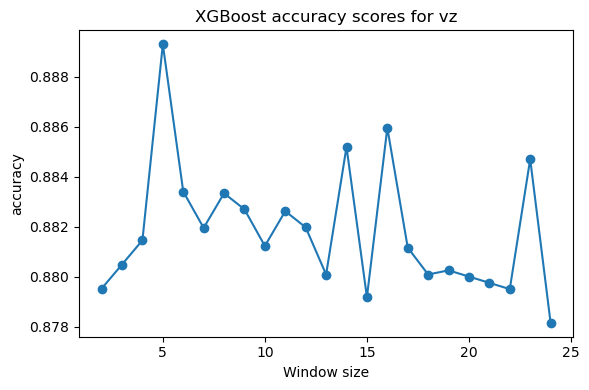

In [21]:
from xgboost import XGBClassifier
accuracies_xgb = {}
for window in spread_range:
    accuracies_xgb[window] = {}
    for stock_ind in range(len(stocks)):
        model = XGBClassifier(tree_method = "hist", device="cuda")
        accuracies_xgb[window][stock_ind] = accuracies_model(model ,window,stock_ind, map=False)

plot_accuracies(accuracies_xgb, "XGBoost")

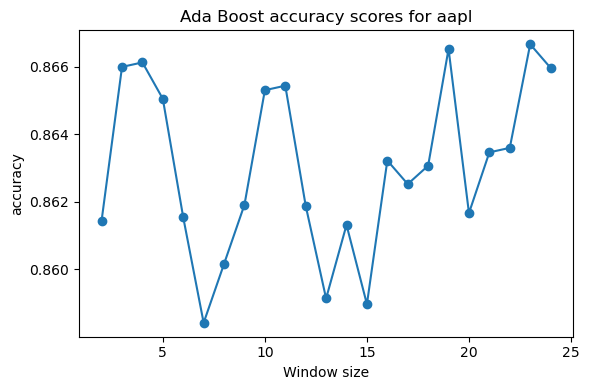

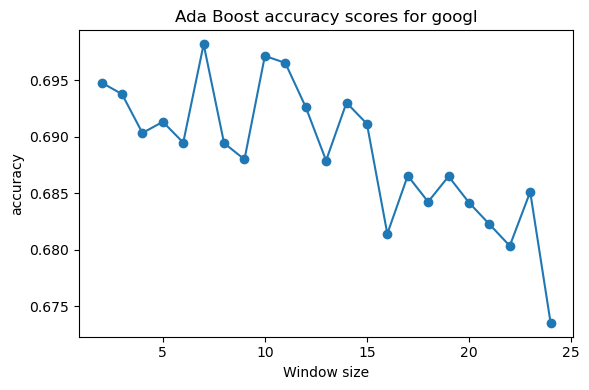

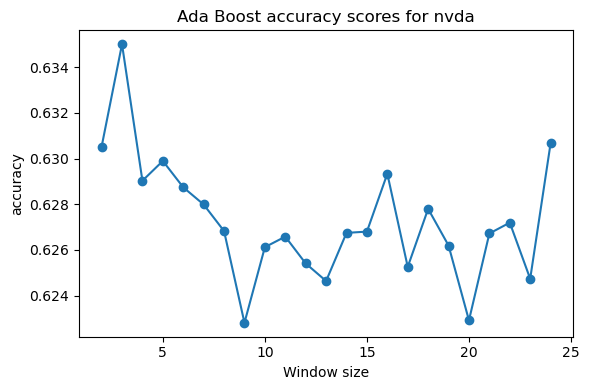

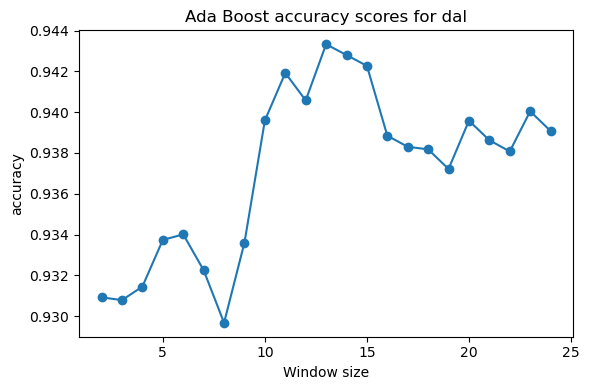

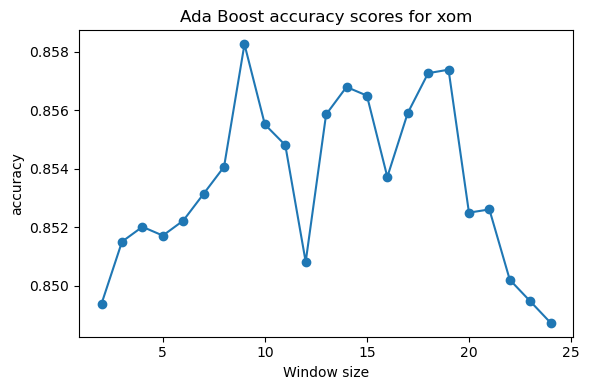

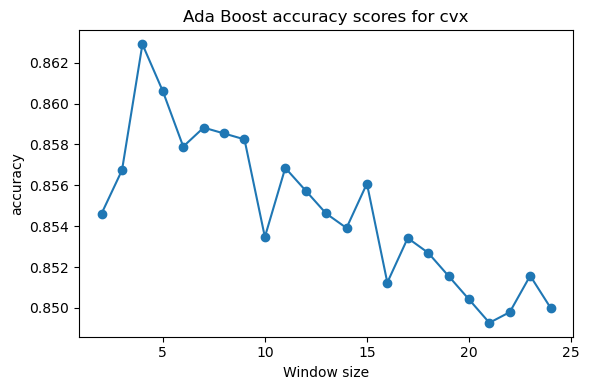

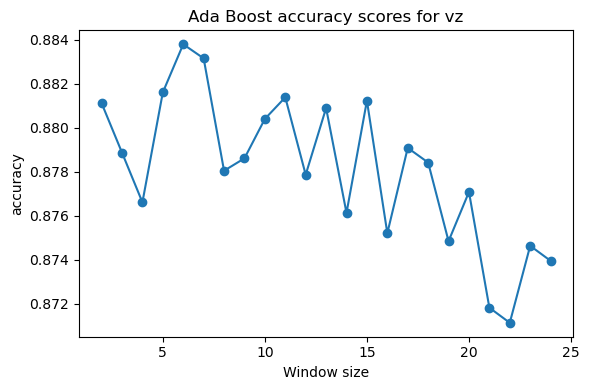

In [22]:
accuracies_ada = {}
for window in spread_range:
    accuracies_ada[window] = {}
    for stock_ind in range(len(stocks)):
        ada_model = AdaBoostClassifier(n_estimators=100,random_state=121)
        accuracies_ada[window][stock_ind] = accuracies_model(ada_model,window,stock_ind,map=False)
plot_accuracies(accuracies_ada, "Ada Boost")

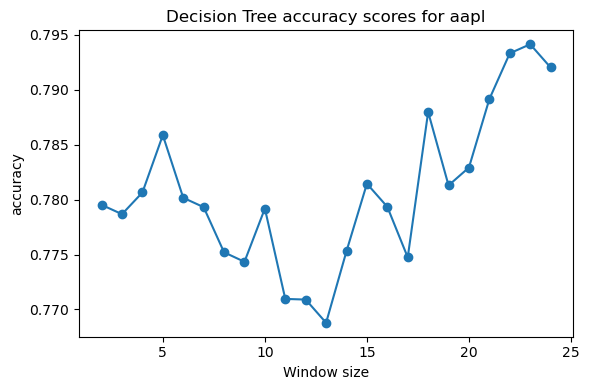

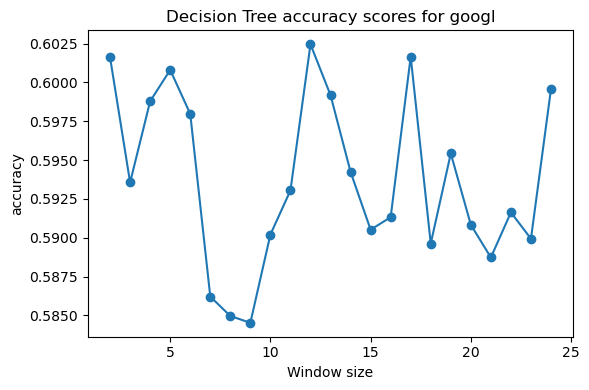

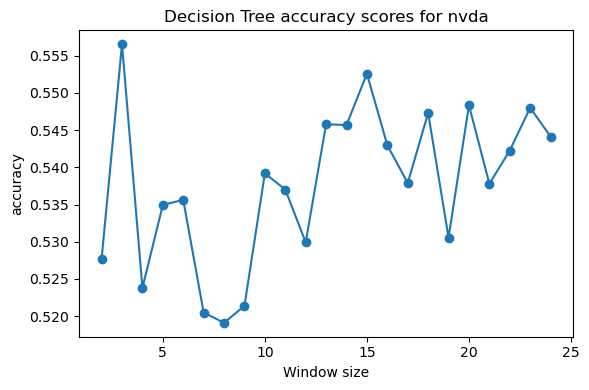

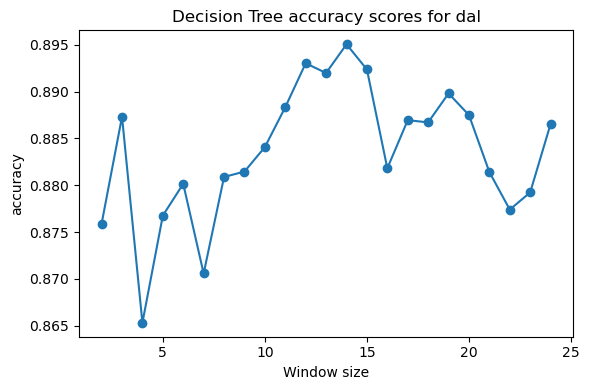

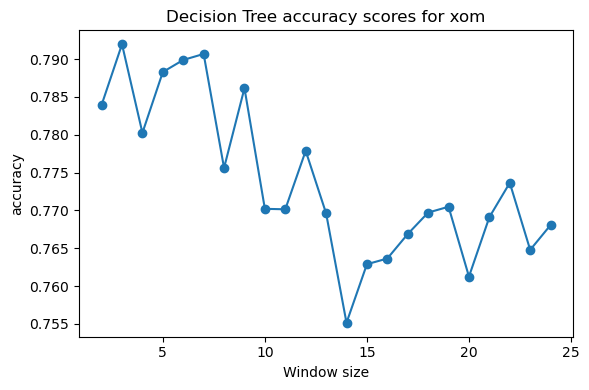

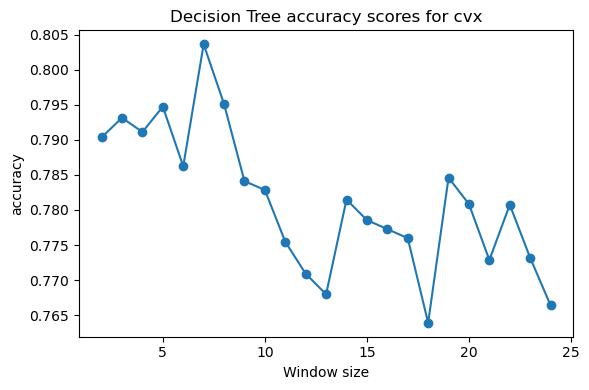

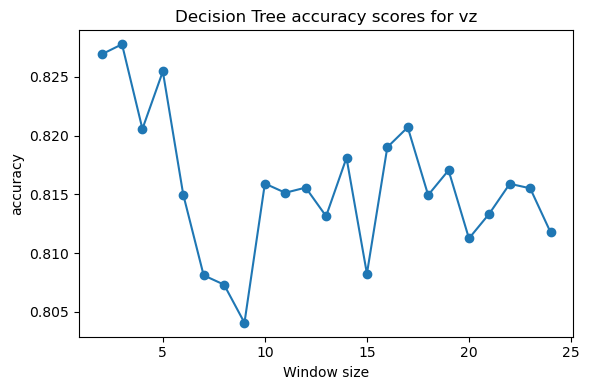

In [23]:
accuracies_decision = {}
for window in spread_range:
    accuracies_decision[window] = {}
    for stock_ind in range(len(stocks)):
        decision_model = DecisionTreeClassifier(random_state=rs)
        accuracies_decision[window][stock_ind] = accuracies_model(decision_model,window,stock_ind,map=False)
plot_accuracies(accuracies_decision, "Decision Tree")

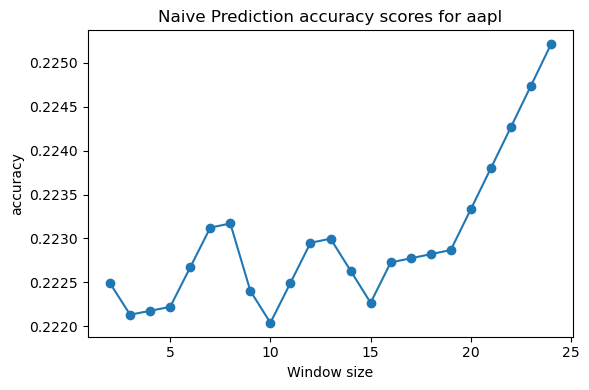

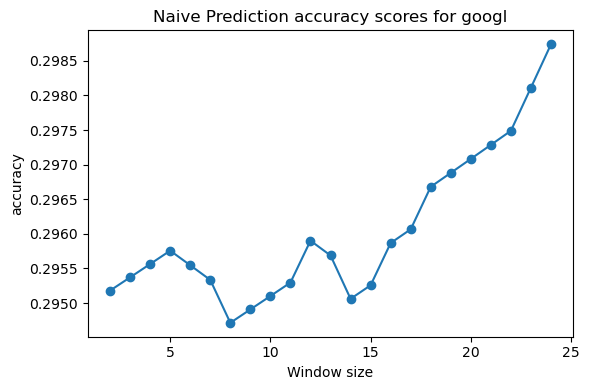

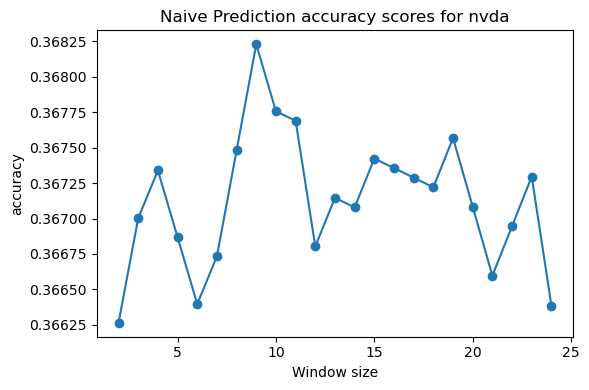

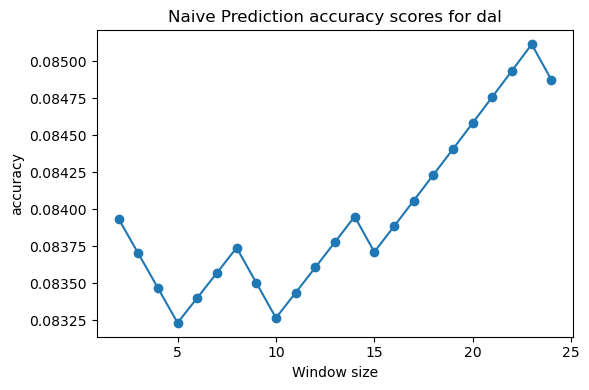

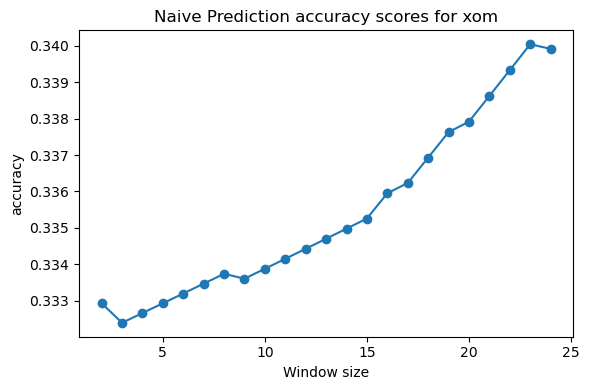

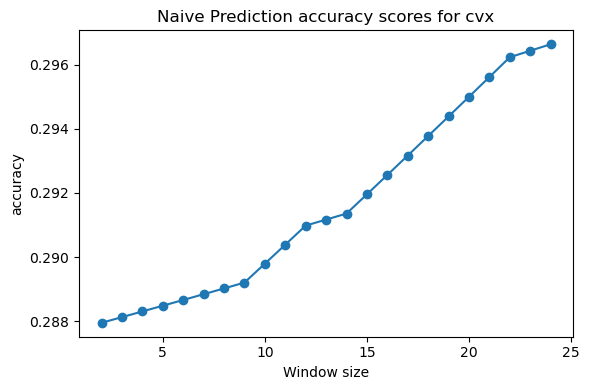

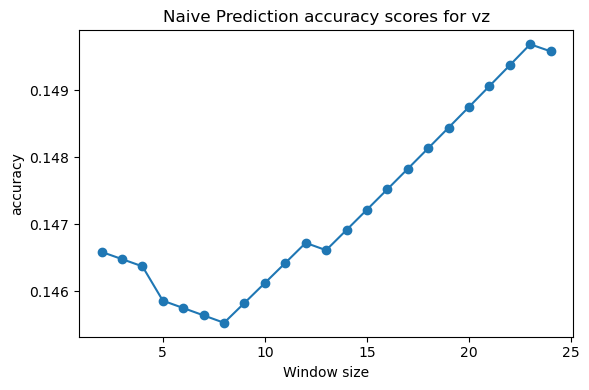

In [24]:
#Naive Prediction
accuracies_naive = {}
for window in spread_range:
    accuracies_naive[window] = {}
    for s_ind in range(len(stocks)):
        testing_list = testing_lists[window][s_ind]
        testing_list = testing_lists[window][s_ind]
        a=0 
        for i in range(ns):
            a+= accuracy_score([1]*len(testing_list[i][1]),testing_list[i][1])
        a=a/ns
        accuracies_naive[window][s_ind] = a
plot_accuracies(accuracies_naive, "Naive Prediction")

In [25]:
accuracies_naive_0 = {}
for window in spread_range:
    accuracies_naive_0[window] = {}
    for s_ind in range(len(stocks)):
        accuracies_naive_0[window][s_ind] = 1 -accuracies_naive[window][s_ind]

In [26]:
from copy import deepcopy
model_forest = RandomForestClassifier(
    n_estimators = 100, # number of trees in ensemble
    max_depth = 10, # max_depth of each tree
    min_samples_leaf = 5, 
    max_features = 5, # default is round(sqrt(num_features)), which in this case is 1.
    random_state = 121 # for consistency
    )

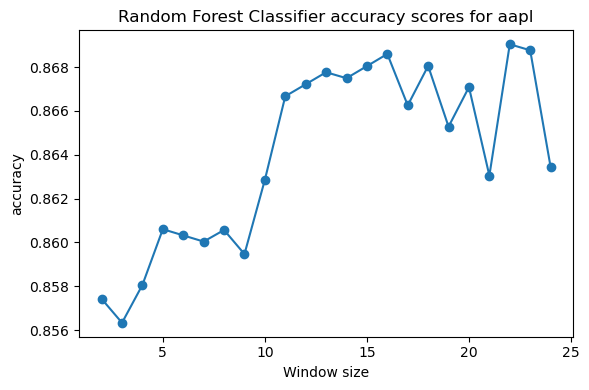

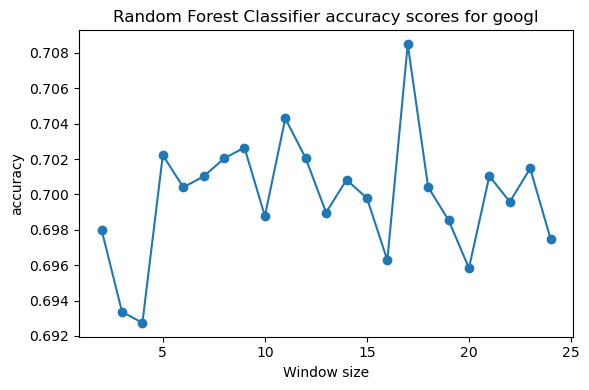

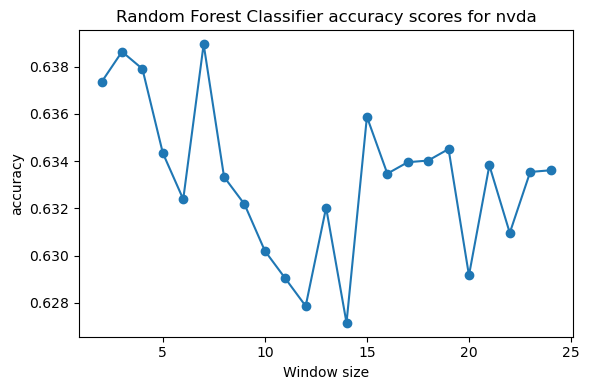

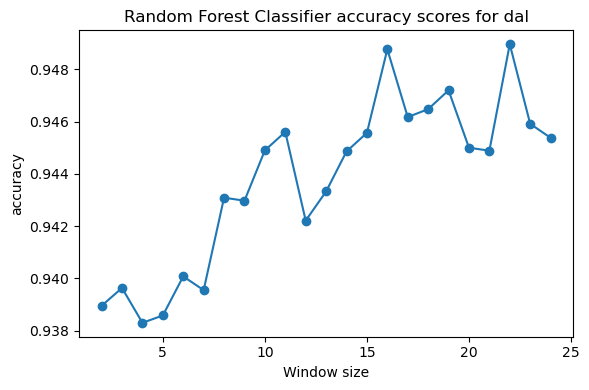

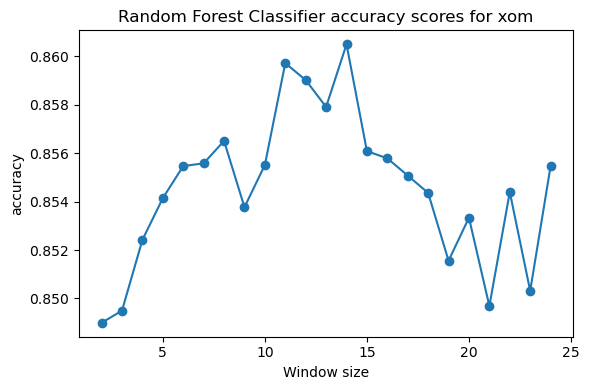

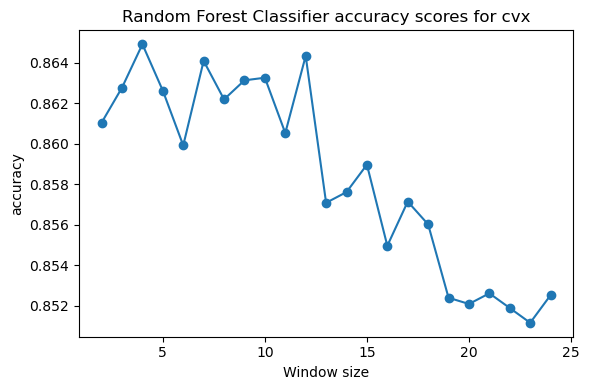

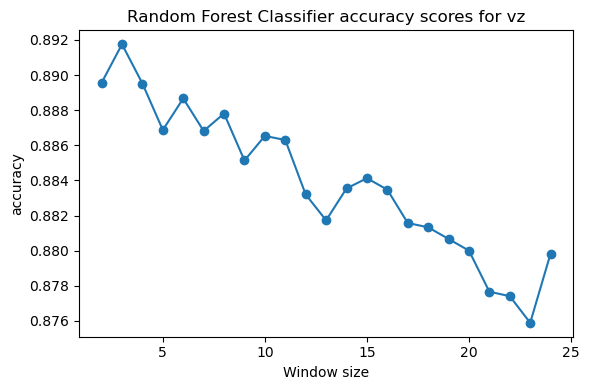

In [27]:
accuracies_rfc = {}
for window in spread_range:
    accuracies_rfc[window] = {}
    for stock_ind in range(len(stocks)):
        rfc_model = deepcopy(model_forest)
        accuracies_rfc[window][stock_ind] = accuracies_model(rfc_model,window,stock_ind,map=False)
plot_accuracies(accuracies_rfc, "Random Forest Classifier")

In [28]:
accuracies_over_models = [ accuracies_naive_0,accuracies_naive, accuracies_xgb,accuracies_ada,accuracies_decision,accuracies_rfc]
model_names = ["Naive_0","Naive_1","XGBoost","Ada Boosting", "Decision Tree","Random Forest Classifier" ]

In [29]:
best_accs = {}
for stock_ind in range(len(stocks)):
    best_accs[stock_ind] = {}
    for ind, model in enumerate(accuracies_over_models):
        accs_model_windows = [model[window][stock_ind] for window in spread_range]
        max_acc_model = max(accs_model_windows)
        best_accs[stock_ind][ind] = (max_acc_model,spread_range[accs_model_windows.index(max_acc_model)])

In [30]:
data_after_training = {}
data_after_training["Models(rows)/Stocks(columns)"] = model_names
for stock in stocks:
    data_after_training[stock] = []
    for ind, model in enumerate(accuracies_over_models):
        data_after_training[stock].append(best_accs[stocks.index(stock)][ind])
df_test_scores = pd.DataFrame(data_after_training)

In [31]:
df_test_scores

,Models(rows)/Stocks(columns),aapl,googl,nvda,dal,xom,cvx,vz
0,Naive_0,"(0.7779591836734694, 10)","(0.7052845528455285, 8)","(0.6337349397590362, 2)","(0.9167676767676768, 5)","(0.6676056338028169, 3)","(0.7120481927710843, 2)","(0.8544715447154472, 8)"
1,Naive_1,"(0.22521008403361345, 24)","(0.2987394957983193, 24)","(0.36822810590631366, 9)","(0.08511530398322852, 23)","(0.340041928721174, 23)","(0.2966386554621849, 24)","(0.14968553459119496, 23)"
2,XGBoost,"(0.8651452282157676, 18)","(0.6775257731958763, 15)","(0.6058823529411764, 24)","(0.9458677685950413, 16)","(0.8539094650205762, 14)","(0.8605427974947808, 21)","(0.8892929292929294, 5)"
3,Ada Boosting,"(0.8666666666666666, 23)","(0.6981744421906693, 7)","(0.635010060362173, 3)","(0.9433264887063654, 13)","(0.8582484725050918, 9)","(0.8629032258064516, 4)","(0.8838056680161943, 6)"
4,Decision Tree,"(0.7941299790356393, 23)","(0.6024590163934427, 12)","(0.5565392354124749, 3)","(0.8950617283950617, 14)","(0.7919517102615694, 3)","(0.8036511156186611, 7)","(0.8277665995975856, 3)"
5,Random Forest Classifier,"(0.8690376569037659, 22)","(0.7084886128364389, 17)","(0.6389452332657201, 7)","(0.9489539748953975, 22)","(0.8604938271604938, 14)","(0.8649193548387097, 4)","(0.8917505030181087, 3)"
